In [30]:
!pip3 install torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [31]:
# from google.colab import files
# uploaded = files.upload()

In [32]:
# load data
data_raw = pd.read_csv("Bitcoin.csv")
data_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


<AxesSubplot:>

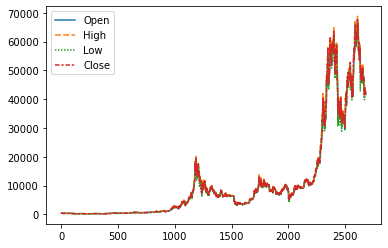

In [33]:
date = data_raw.iloc[:, 0] 
data = data_raw.iloc[:, 1:] 

# date 변수를 제외한 변수값들만 사용할 예정입니다

sns.lineplot(data=data.iloc[:, :4])

# 데이터 전처리


In [34]:
# hyper parameters
seq_length = 7 # 과거 일주일의 데이터로
output_dim = 1 # 하루의 종가를 예측
data_dim = 6 # input data의 feature 개수: ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']
hidden_dim = 9

learning_rate = 0.001
iterations = 2000

In [35]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :] # 과거 7일의 모든 변수를 x값에 저장
        _y = time_series[i + seq_length, 3]  # Next close price 하나의 값을 y값에 저장
        if i == 0: # 없으면 너무 많이 프린트되니까 예시로 몇개만 프린트합시다!
          print(_x, "->", _y) # [[]] 안의 값들을 사용해 -> [] 이 값을 예측
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [36]:
# scaling data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# split train-test set
train_size = len(data) - 100 
train_set_scaled = scaled_data[0:train_size]
test_set_scaled = scaled_data[train_size - seq_length:]

# make train-test dataset to input
trainX, trainY = build_dataset(train_set_scaled, seq_length)
testX, testY = build_dataset(test_set_scaled, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY).view(-1,1)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY).view(-1,1)

# [학습에 사용할 데이터(X)] -> [예측할 값(Y)]

[[4.28907290e-03 3.73944128e-03 4.24270741e-03 4.14358659e-03
  4.14358659e-03 4.31449169e-05]
 [4.15542811e-03 3.57446063e-03 3.64887469e-03 3.65546320e-03
  3.65546320e-03 8.14009011e-05]
 [3.66922344e-03 3.15121937e-03 3.21734240e-03 3.21556748e-03
  3.21556748e-03 9.11925571e-05]
 [3.23240062e-03 3.08503185e-03 3.29816008e-03 3.42492004e-03
  3.42492004e-03 8.81834001e-05]
 [3.43147175e-03 2.92652603e-03 3.34797093e-03 3.27529593e-03
  3.27529593e-03 5.88825143e-05]
 [3.29810962e-03 2.84617930e-03 3.40761407e-03 3.32472547e-03
  3.32472547e-03 5.18945799e-05]
 [3.34251927e-03 3.35131324e-03 3.39352244e-03 3.82390359e-03
  3.82390359e-03 1.11650038e-04]] -> 0.003637136472254978
[[0.76157943 0.80720959 0.75994958 0.81888099 0.81888099 0.13969833]
 [0.81875323 0.80385808 0.80582259 0.79579902 0.79579902 0.10486018]
 [0.79594759 0.81237912 0.80827818 0.79820095 0.79820095 0.09914165]
 [0.79784207 0.80472308 0.80898939 0.8130458  0.8130458  0.0925607 ]
 [0.81302681 0.81935403 0.81698076

In [37]:
trainX_tensor.size() # 총 train data 개수, 과거 며칠의 데이터를 사용할 것인지, 총 몇개의 feature를 사용하는지

torch.Size([2576, 7, 6])

# 모델 훈련

In [38]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = torch.nn.Linear(hidden_size, output_size, bias=True)
  
  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x[:, -1])  
    return x

In [39]:
# model
model = Net(data_dim, hidden_dim, output_dim, 1) 

# Set loss and optmizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
# start training
loss_list = []
for i in range(iterations):
  
    outputs = model(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i % 100 == 0:
      print(f"Epochs: {i}, Loss: {loss.item()}")

Epochs: 0, Loss: 0.2401835322380066
Epochs: 100, Loss: 0.011148552410304546
Epochs: 200, Loss: 0.0003611536230891943
Epochs: 300, Loss: 0.0003236768243368715
Epochs: 400, Loss: 0.0003014871326740831
Epochs: 500, Loss: 0.00028590959846042097
Epochs: 600, Loss: 0.00027312690508551896
Epochs: 700, Loss: 0.0002617357240524143
Epochs: 800, Loss: 0.000251347926678136
Epochs: 900, Loss: 0.00024188499082811177
Epochs: 1000, Loss: 0.00023332265845965594
Epochs: 1100, Loss: 0.0002256262523587793
Epochs: 1200, Loss: 0.00021874516096431762
Epochs: 1300, Loss: 0.00021261682559270412
Epochs: 1400, Loss: 0.0002071709168376401
Epochs: 1500, Loss: 0.00020233176473993808
Epochs: 1600, Loss: 0.00019802077440544963
Epochs: 1700, Loss: 0.0001941588707268238
Epochs: 1800, Loss: 0.0001906692486954853
Epochs: 1900, Loss: 0.00018748034199234098


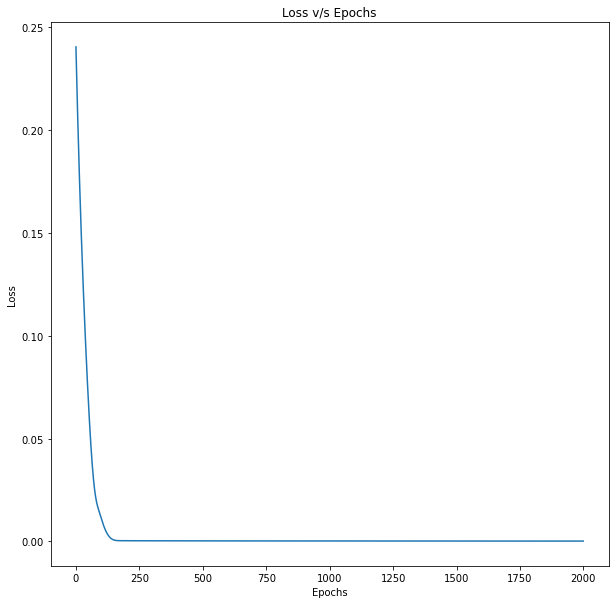

In [41]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(iterations)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 성능 확인

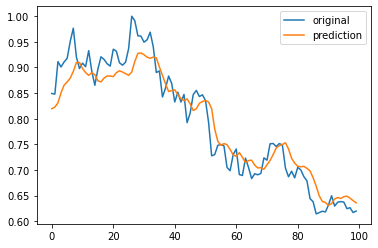

In [42]:
plt.plot(testY)
plt.plot(model(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

In [43]:
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output) / target)) 

print("MAPE(Mean Absolute Percentage Error) : " + str(MAPELoss(model(testX_tensor), testY_tensor).item()))

MAPE(Mean Absolute Percentage Error) : 0.034481231123209
